## Análise exploratória de dados

O objetivo desta análise é buscar conhecer melhor os dados fornecidos, as distribuições envolvidas e as características cruciais para melhorar o tratamento dos dados, antes que seja feita a modelagem. 



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from user_functions import is_binary


dataset = pd.read_csv('data/dataset.csv')

### Carregando os dados e "preparando terreno" para a análise

Para facilitar o entendimento dos dados, vamos criar um `metadata` contendo os tipos de cada coluna.

A construção do `metadata` é dada por informações:

- name: Nome da variável
- role: Indica onde a variável se aplica, pode ser *id*, *target* ou *input*;
- level: Indica como o dado contido deve ser interpretado, pode ser *nominal*, *interval*, *ordinal*, *binary* ou *categoric*;
- keep: Se a variável deve ou não ser mantida na análise, assume valores *True* ou *False*;
- dtype: O tipo do dado encontrado na coluna, pode ser *int*, *float* ou *str*

(fonte:https://www.kaggle.com/bertcarremans/data-preparation-exploration)

No caso do conjunto de dados fornecido, a variável alvo é a `sent_to_analysis`.

Aproveitando a construção do `metadata`, as variáveis que são inteiras compostas por valores faltantes são marcadas com `keep = false` e não serão utilizadas nas análises.

In [2]:
data = []


for c in dataset.columns:
    if c == 'sent_to_analysis':
        role = 'target'
        keep = False
    elif c == 'id':
        role = 'id'
        keep = False
    elif dataset[c].isnull().all():
        keep = False
    else:
        role = 'input'
        keep = True
    
    dtype = dataset[c].dtype
    
    if is_binary(dataset[c], allow_na=True):
        level = 'binary'
    elif dtype == float:
        level = 'interval'
    elif dtype == int:
        level = 'ordinal'
    elif dtype == 'object':
        level = 'categoric'
        
    # Fix for case ordinal is keeped like interval:
    if (dtype == float):
        condition_1 = ~is_binary(dataset[c], allow_na=True)
        condition_2 = all((x % 1) == 0 for x in dataset[c])
        if (condition_1) & (condition_2):
            level = 'ordinal'
    

    metadata_dict = {
        'name': c,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    
    data.append(metadata_dict)

metadata = pd.DataFrame(
    data, columns=['name', 'role', 'level', 'keep', 'dtype']
).set_index('name')

target = metadata[metadata['role'].values == 'target'].index[0]

# Cast target to int
dataset.loc[:, target] = pd.to_numeric(dataset.loc[:, target], downcast='signed')

# Remove all cases that target is missing
dataset = dataset[~dataset[target].isna()]


Com o `metadata` definido, este será utilizado para filtrar o dataset de um modo mais simples, conforme for conveniente e com melhor legibilidade. 

Dito isso, podemos iniciar a análise exploratória de dados.

### Análise Exploratória

A análise será dividida segundo os tipos de dados presentes. Segundo o `metadata`, os tipos de variáveis presentes são:

In [3]:
metadata['level'].unique()

array(['ordinal', 'interval', 'categoric', 'binary'], dtype=object)

Vamos verificar as proporções entre as categorias assumidas pela variável alvo, que no caso específico é tida como binária.

In [4]:
dataset[target].value_counts()

0.0    31579
1.0     3269
Name: sent_to_analysis, dtype: int64

In [5]:
print('Proportion of category 1: {:.1%}'.format(dataset[target].sum() / dataset[target].count()))

Proportion of category 1: 9.4%


É visível que a variável alvo está desbalanceada, uma vez que apenas 9% dos casos possuêm o alvo igual à 1. Isso quer dizer que já uma proporção muito maior de uma única categoria do que de outra.

Isso é um grande problema para modelos de machine learning, uma vez que o treinamento do modelo com esses valores alvo faz com que exista uma tendência a classifica-lo de acordo com a categoria mais frequênte, independente dos dados fornecidos. 

Para evitar esse fenômeno, deverá ser utilizada alguma técnica de balanceamento de dados, tais como SMOTE ou SMOTEENN, por exemplo.

#### Dados do tipo `interval`: 



In [6]:
selection = metadata.loc[
    (metadata['level'] == 'interval') & (metadata['keep'] == True),
].index

dataset[selection].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34848 entries, 0 to 35020
Data columns (total 5 columns):
monthly_income      34846 non-null float64
collateral_value    34827 non-null float64
loan_amount         34845 non-null float64
collateral_debt     24540 non-null float64
monthly_payment     33569 non-null float64
dtypes: float64(5)
memory usage: 1.6 MB


**Valores *outliers*:**

De início, é interessante verificar se existem casos de valores *outliers* nas variáveis em questão e decidir uma forma de trata-los. Vamos visualizar o *box plot* dessas variáveis.

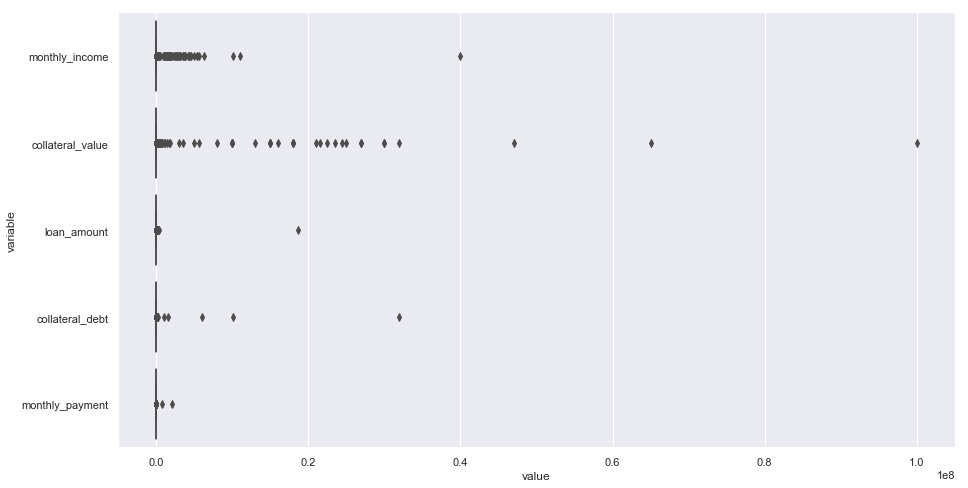

In [7]:
sns.set(rc={'figure.figsize':(15,8)})

sns.boxplot(
    x="value",
    y="variable",
    data=pd.melt(dataset[selection].dropna()),
    orient='h'
)

In [8]:
dataset[selection].dropna().describe()

,monthly_income,collateral_value,loan_amount,collateral_debt,monthly_payment
count,2.327000e+04,2.327000e+04,2.327000e+04,2.327000e+04,2.327000e+04
mean,1.378049e+04,5.434043e+04,1.269096e+04,7.278121e+03,6.743763e+02
std,3.170199e+05,1.066745e+06,1.230961e+05,2.239416e+05,1.508434e+04
min,1.000000e+00,2.000000e+01,2.000000e+03,0.000000e+00,0.000000e+00
25%,2.000000e+03,1.300000e+04,5.000000e+03,0.000000e+00,2.748900e+02
50%,3.045000e+03,2.000000e+04,9.000000e+03,9.500000e+00,4.205900e+02
75%,5.000000e+03,3.000000e+04,1.500000e+04,7.000000e+03,6.597300e+02
max,4.000400e+07,1.000000e+08,1.872000e+07,3.200000e+07,2.163889e+06


Concluímos que todas as variáveis de valores reais possuêm valores outliers. Vamos estudar a distribuição de cada uma delas individualmente, utilizando um gráfico de valor em função do centil para cada caso.

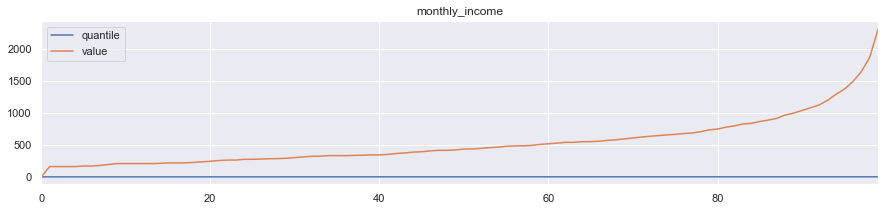

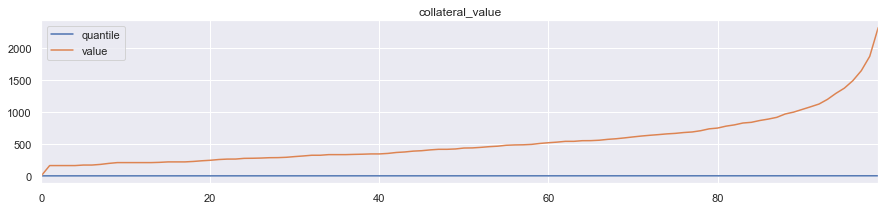

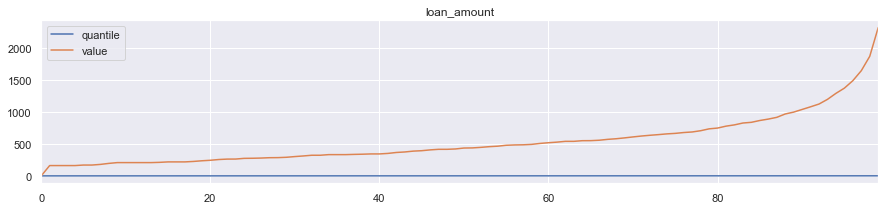

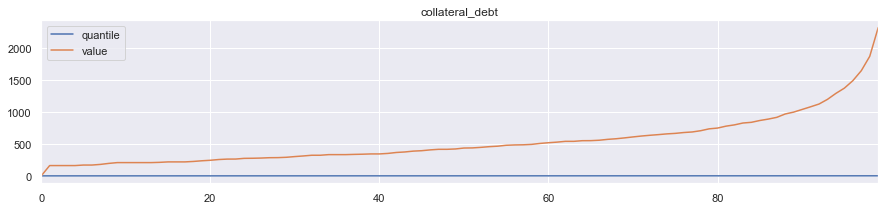

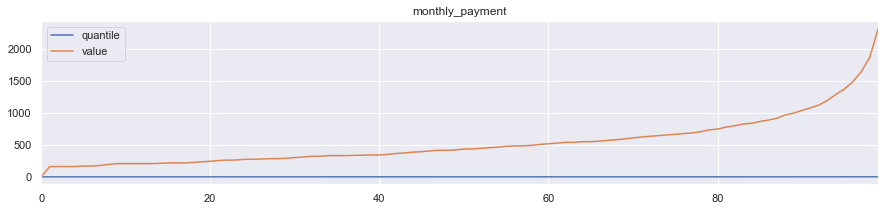

In [9]:
plt.rcParams["figure.figsize"] = (15,3)

q = np.arange(0, 1.0, 0.01)
for c in dataset[selection].columns:
    v = np.quantile(dataset['monthly_payment'].dropna(), q)
    pd.DataFrame({'quantile': q, 'value': v}).plot()
    plt.title(c)


Segundo os gráficos acima, em todos os casos os valores encontram-se regulares até, aproximadamente, o 90º centil. Os valores tidos como *outliers* correspondem apenas ao centésimo centil. 

Desta forma, as opções que temos para corrigir esses valores são:
1. Utilizar a mediana;
2. Regressão linear para o valor em função do centil, com coeficientes determinados com os valores até o 90º centil. 

A escolha será a de utilizar a mediana pois, além de mais simples, evitaria distorcer os resultados em casos de preenchimento desses campos com digitos a mais, sem que cause grandes impactos no modelo final (dado que, nesses casos, a ordem de grandeza da mediana é praticamente a mesma dos demais centís até próximo do 90º).

A estratégia escolhida para determinar quais valores são, de fato, *outliers* é avaliar quais valores são superiores à uma vez e meia o valor do terceiro quartil (*IRC range*)

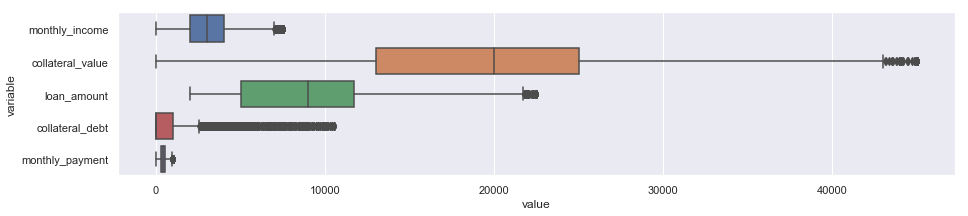

In [10]:
for c in dataset[selection].columns:
    q3 = np.quantile(dataset[c].dropna(), .75)
    replacement = np.quantile(dataset[c].dropna(), .5)
    dataset.loc[dataset[c] > 1.5 * q3, c] = replacement
    
sns.boxplot(
    x="value",
    y="variable",
    data=pd.melt(dataset[selection].dropna()),
    orient='h'
)

Como não há muitos valores relevantes nos limites inferiores, não foi necessário corrigir para valores muito pequenos.

**Valores faltantes:**

O conjunto de dados original contém alguns valores faltantes. Abaixo seguem a proporção de valores faltantes em cada variável.

In [11]:
missing = dataset[selection].isna()
missing.sum() / len(missing)

monthly_income      0.000057
collateral_value    0.000603
loan_amount         0.000086
collateral_debt     0.295799
monthly_payment     0.036702
dtype: float64

O caso de maior destaque é para `collateral_debt` que, segundo a descrição fornecida, trata-se do "Valor que o automovel do cliente tem de dívida...".

Há diferentes abordagens para tratar tais valores faltantes:
- Preencher com a média;
- Preencher com a mediana;
- Preencher com zero ou outro valor;
- Remover a variável inteira que contém muitos valores faltantes
entre outras. 

A escolha para o caso de `collateral_debt` deve ser feita de acordo com seu significado: preencher com a média ou a mediana, implicará em casos em que o valor real seria baixo ou nulo serem penalizados pelo modelo. Porém, ao preencher dessa maneira, evita uma distorção muito grande desse valor para o caso de o valor faltante ser, na realidade, um grande débito. 

A escolha feita foi de preencher utilizando a mediana. 

In [12]:
for c in dataset[selection].columns:
    dataset.loc[dataset[c].isna(), c] = np.quantile(dataset[c].dropna(), .5)

missing = dataset[selection].isna()
missing.sum() / len(missing)

monthly_income      0.0
collateral_value    0.0
loan_amount         0.0
collateral_debt     0.0
monthly_payment     0.0
dtype: float64

**Distribuição entre as variáveis:**

Com os devidos ajustes feitos, podemos observar como cada variável está distribuída e como se relacionam com as demais aos pares.

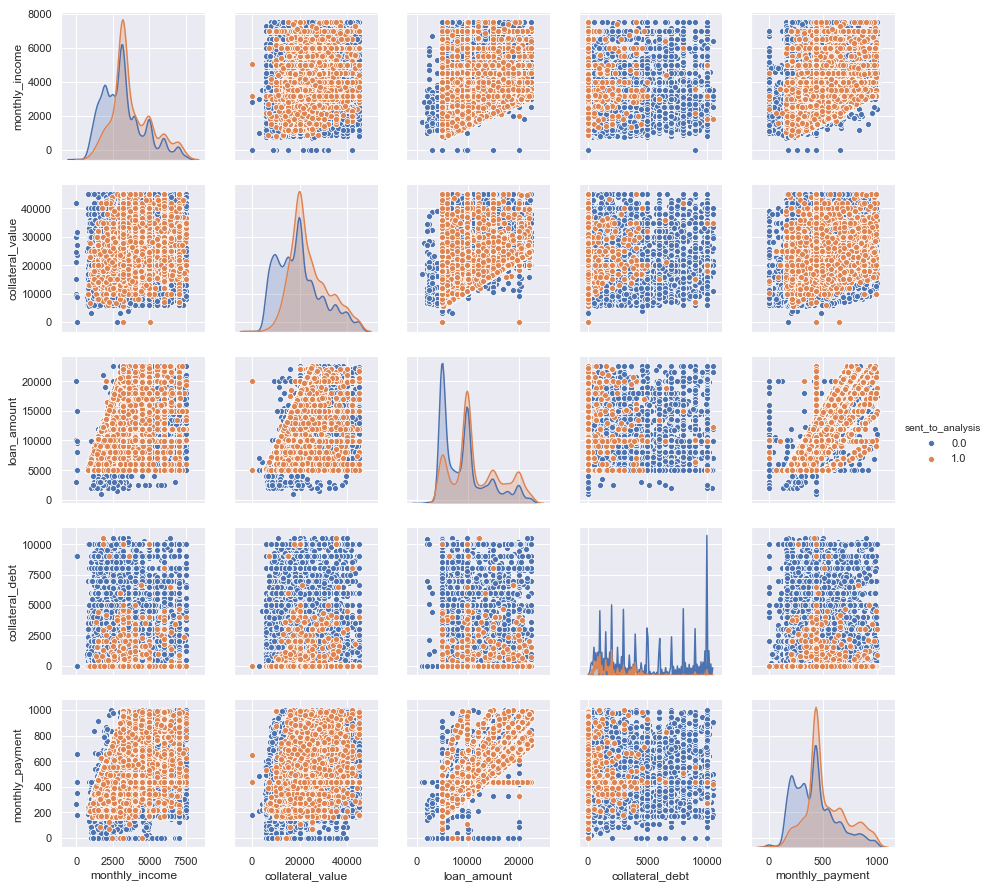

In [13]:
with np.errstate(divide='ignore',invalid='ignore'):
    pairplot_selection = selection.to_list() + [target]
    sns.pairplot(dataset[pairplot_selection], hue=target, vars=selection)

#### Dados do tipo `ordinal`: 


In [14]:
selection = metadata.loc[
    (metadata['level'] == 'ordinal') & (metadata['keep'] == True),
].index

dataset[selection].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34848 entries, 0 to 35020
Data columns (total 2 columns):
age          34846 non-null float64
auto_year    34844 non-null float64
dtypes: float64(2)
memory usage: 2.0 MB


Os únicos cuidados necessários são:
- corrigir valores faltantes;
- corrigir valores com aparente preenchimento incorreto

Os casos de preenchimento incorreto tratam-se ou de idades muito grandes ou inferiores à 18 anos no campo `age`, e para o campo `auto_year`, valor superior ao ano corrente, somado de 1 (devido ao fato de carros de modelo do próximo ano poderem ser vendidos no ano corrente).


In [15]:
for c in dataset[selection].columns:
    dataset.loc[dataset[c].isna(), c] = dataset[c].dropna().median()
